Projet : Accident de la route
==============

Le projet qui vous a été attribué est le suivant : Accidents routiers en France

- Étape 1/ Exploration des données + DataViz’ : Deadline Vendredi 15 Mars
Votre première tâche consistera à définir le <span style="color: #26B260">**contexte**</span> et le <span style="color: #26B260">**périmètre du projet**</span> : j’attends que vous preniez vraiment le temps de bien comprendre le projet et de vous renseigner au mieux sur les notions que celui-ci va introduire.

Il faudra ensuite prendre en main et <span style="color: #26B260">**découvrir votre jeu de données**</span> et faire une <span style="color: #26B260">**analyse presque exhaustive**</span> de celui-ci afin de mettre en lumière la <span style="color: #26B260">**structure**</span>, les <span style="color: #26B260">**difficultés**</span> et <span style="color: #26B260">**eventuels</span> biais** du dataset.

Vous pourrez utiliser ce [**template : Template - Rapport exploration des données**](https://onedrive.live.com/edit?id=1DD0D0EFB906825!9189&resid=1DD0D0EFB906825!9189&ithint=file%2cxlsx&ct=1708768365134&wdOrigin=OFFICECOM-WEB.MAIN.UPLOAD&wdPreviousSessionSrc=HarmonyWeb&wdPreviousSession=7b89bcec-2c24-4972-bd6b-334e7b3df731&wdo=2&cid=01dd0d0efb906825)
J’attendrai également au moins **5 représentations graphiques** construites à partir de votre jeu de données, visuelles et surtout pertinentes. Pour chacune d’elle j’attendrai :

Un <span style="color: #26B260">**commentaire**</span> précis, qui analyse la figure et apporte un avis “métier”.
Une <span style="color: #26B260">**validation du constat**</span> par des manipulations de données, ou un test statistique.


## Contexte

L’objectif de ce projet est d’essayer de prédire la gravité des accidents routiers en France. Les prédictions seront basées sur les données historiques.

La première étape est d’étudier et appliquer des méthodes pour nettoyer le jeu de données. 
La deuxième étape est d’extraire les caractéristiques qui semblent être pertinentes pour estimer la gravité d’accidents. 

On pourra créer un modèle prédictif, une fois l’entraînement du modèle effectué, nous allons comparer notre modèle avec les données historiques. 
Ensuite, à partir de ces résultats, on peut développer un scoring des zones à risque en fonction des informations météorologiques, l’emplacement géographique (coordonnées GPS, images satellite, …)



### Informations sur les données

Les données vont de 2005 à 2021, elles sont annuelles et composées de 4 fichiers (Caractéristiques – Lieux – Véhicules – Usagers) au format csv. Les données ont été anonymisées par le service de gouvernement. 
Les données répertorient l'intégralité des accidents corporels de la circulation sur le territoire français (France métropolitaine et les DOM-TOM).
Le n° d'identifiant de l’accident (Cf. "Num_Acc") présent dans ces 4 rubriques permet d'établir un lien entre toutes les variables qui décrivent un accident.\
Quand un accident comporte plusieurs véhicules, il faut aussi pouvoir le relier chaque véhicule à ses occupants. Ce lien est fait par la variable id_vehicule.


La variable cible est "grav" dans le dataset d'usagers.


### Notions introduites :
Qu'est-ce qui peut définir un accident comme grave ? 
Il y a :
- le type d'accident :  df_car
- la temporalité de l'accident (date et heure) : df_car
- le lieu de l'accident : df_car
- les caractéristiques de l'accident : df_car
- les informations météorologiques de l'accident : df_car['atm'],
- l'emplacement géographique de l'accident, df_car[['dep' , 'com', 'agg', 'int','adr']], 
- les circuits de l'accident,

Selon l'OMS, en 2023, 53% des décès dus aux accidents concernent des usagers de la route vulnérables, notamment : les piétons (23 %) ; les conducteurs de deux-roues et de trois-roues motorisés tels que les motocyclettes (21 %) ; les cyclistes (6 %) ; et les usagers d’engins de micro-mobilité comme les trottinettes électriques (3 %).

D'après les données disponibles pour 2021 de la commission européenne, 52 % des décès dus à des accidents de la route sont survenus en zone rurale, contre 39 % en zone urbaine et 9 % sur des autoroutes. Trois victimes sur quatre (78 %) sont des hommes.

En zone urbaine, les usagers vulnérables de la route (piétons, cyclistes et usagers de deux-roues motorisés) représentent près de 70 % du total des décès.

### Import des données

In [1]:
# import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

100

In [10]:
# import du dataset : usagers impliqués
df_usa22 = pd.read_csv("dataset/usagers-2022.csv", sep=';')
df_usa21 = pd.read_csv("dataset/usagers-2021.csv", sep=';')
df_usa20 = pd.read_csv("dataset/usagers-2020.csv", sep=';')
df_usa19 = pd.read_csv("dataset/usagers-2019.csv", sep=';')

# regroupper les datasets usagers en 1 dataset usager
df_usa = pd.concat([df_usa22, df_usa21,df_usa20,df_usa19])
df_usa.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1


On observe 2 lignes pour le même numéro d'accident, il s'agit non pas d'un doublon mais de 2 usagers différents impliqués dans l'accident.

In [11]:
# import des datasets des lieux des accidents
# décrit le lieu principal de l’accident même si celui-ci s’est déroulé à une intersection
df_lieux22 = pd.read_csv("dataset/lieux-2022.csv", sep=';')
df_lieux21 = pd.read_csv("dataset/lieux-2021.csv", sep=';')
df_lieux20 = pd.read_csv("dataset/lieux-2020.csv", sep=';')
df_lieux19 = pd.read_csv("dataset/lieux-2019.csv", sep=';')

# regroupper les datasets en 1 seul dataset lieux
df_lieux = pd.concat([df_lieux22, df_lieux21,df_lieux20,df_lieux19])
df_lieux.head()

/tmp/ipykernel_1017/1264010108.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux22 = pd.read_csv("dataset/lieux-2022.csv", sep=';')


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202200000001,4,TEIL(vieille route du),0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
1,202200000002,4,NaN,0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
2,202200000003,3,ROND POINT DE BREZILLET,0.0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,5,1,50
3,202200000004,4,QUATORZE JUILLET (RUE DU),0.0,NaN,1,1,0,2,(1),(1),1,NaN,4,1,0,1,30
4,202200000005,3,ROUTE DE JEAN MOULIN-RN 538,0.0,NaN,2,2,0,1,8,0,1,NaN,-1,1,0,1,80


In [12]:
# import des datasets des caractéristiques des accidents
# décrit les circonstances générales de l’accident
df_carac22 = pd.read_csv("dataset/carcteristiques-2022.csv", sep=';')
df_carac21 = pd.read_csv("dataset/carcteristiques-2021.csv", sep=';')
df_carac20 = pd.read_csv("dataset/caracteristiques-2020.csv", sep=';')
df_carac19= pd.read_csv("dataset/caracteristiques-2019.csv", sep=';')
df_carac22['Num_Acc'] = df_carac22['Accident_Id']

# regroupper les datasets en 1 seul dataset caractéristiques
df_car = pd.concat([df_carac22, df_carac21,df_carac20,df_carac19])
df_car.head()

,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,Num_Acc
0,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000",202200000001
1,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000",202200000002
2,2.022000e+11,20,10,2022,17:15,1,22,22360,2,6,1,2,ROND POINT DE BREZILLET,"48,4931620000","-2,7604390000",202200000003
3,2.022000e+11,20,10,2022,18:00,1,16,16102,2,3,8,6,LOHMEYER (RUE),"45,6926520000","-0,3262900000",202200000004
4,2.022000e+11,19,10,2022,11:45,1,13,13103,1,1,1,2,ROUTE DE JEAN MOULIN-RN 538,"43,6755790366","5,0927031775",202200000005


In [13]:
# import des datasets des véhicules impliqués dans des accidents
# véhicules impliqués
df_veh22 = pd.read_csv("dataset/vehicules-2022.csv", sep=';')
df_veh21 = pd.read_csv("dataset/vehicules-2021.csv", sep=';')
df_veh20 = pd.read_csv("dataset/vehicules-2020.csv", sep=';')
df_veh19 = pd.read_csv("dataset/vehicules-2019.csv", sep=';')

# regroupper les datasets en 1 seul dataset véhicules
df_veh = pd.concat([df_veh22, df_veh21,df_veh20,df_veh19])
df_veh.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,813 952,A01,1,2,0,2,1,9,1,NaN
1,202200000001,813 953,B01,1,7,0,2,2,1,1,NaN
2,202200000002,813 950,B01,2,7,0,2,8,15,1,NaN
3,202200000002,813 951,A01,2,10,0,2,1,1,1,NaN
4,202200000003,813 948,A01,2,7,0,2,1,2,1,NaN


On observe 2 lignes pour le même numéro d'accident, il s'agit non pas d'un doublon mais de 2 véhicules différents impliqués dans l'accident.

#### Regroupper les datasets en 1 dataset

In [14]:
df_lieux['Num_Acc'] = df_lieux['Num_Acc'].astype(str)
df_car['Num_Acc'] = df_car['Num_Acc'].astype(str)
df_veh['Num_Acc'] = df_veh['Num_Acc'].astype(str)
df_usa['Num_Acc'] = df_usa['Num_Acc'].astype(str)

# merge les datasets ensembles
df_temp = pd.merge(df_usa, df_lieux, on="Num_Acc") # usa + lieux
df_temp_2 = pd.merge(df_temp, df_car, on="Num_Acc") # usa + lieux + carac
df = pd.merge(df_temp_2, df_veh, on = ["Num_Acc", "id_vehicule", "num_veh"]) # usa + lieux + carac + veh

# supprimer les doublons
df.drop_duplicates(keep='first')

print(df.shape)
df.head()

(494182, 56)


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1,4,TEIL(vieille route du),0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000",1,2,0,2,1,9,1,NaN
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1,4,TEIL(vieille route du),0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000",1,7,0,2,2,1,1,NaN
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1,4,NaN,0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000",2,7,0,2,8,15,1,NaN
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1,4,NaN,0.0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000",2,10,0,2,1,1,1,NaN
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1,3,ROND POINT DE BREZILLET,0.0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,5,1,50,2.022000e+11,20,10,2022,17:15,1,22,22360,2,6,1,2,ROND POINT DE BREZILLET,"48,4931620000","-2,7604390000",2,7,0,2,1,2,1,NaN


## Data exploration

In [15]:
df.shape

(494182, 56)

In [16]:
df.dtypes.value_counts()

int64      34
object     18
float64     4
Name: count, dtype: int64

#### Affichage des données manquantes par colonnes

In [17]:
# Fonction pour mettre en évidence les données manquants et leur donner un pourcentage 
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

Your selected dataframe has 56 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
lartpc,493100,99.8
occutc,487970,98.7
v2,454640,92.0
Accident_Id,367520,74.4
id_usager,238272,48.2
larrout,132146,26.7
voie,47564,9.6
v1,24596,5.0
adr,6051,1.2
an_nais,5941,1.2


On supprime les colonnes ayant plus de 90 % de manquants.

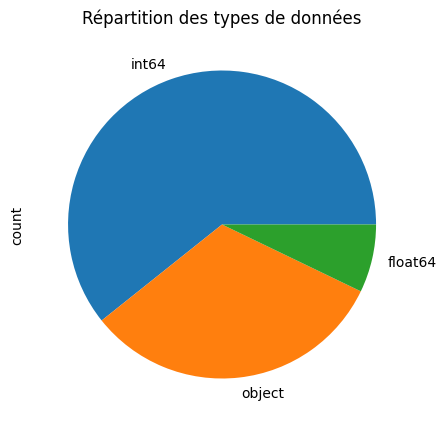

In [18]:
plt.figure(figsize=(5,5))
plt.title("Répartition des types de données")
df.dtypes.value_counts().plot.pie()
plt.show();

### Répartition des données

In [19]:
df.describe()

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,etatp,catr,v1,circ,vosp,prof,plan,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,agg,int,atm,col,senc,catv,obs,obsm,choc,manv,motor,occutc
count,494182.000000,494182.000000,494182.000000,494182.000000,488241.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,469586.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,1.266620e+05,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,494182.000000,6212.000000
mean,2.103371,1.334992,2.531620,1.289149,1982.037854,3.210248,1.945607,1.120652,-0.915798,-0.189758,-0.825056,3.290249,-0.129604,1.836520,0.186393,1.234806,1.289029,1.258105,0.810580,1.464602,60.749028,2.022000e+11,15.673080,6.732609,2020.505067,1.904165,1.621257,2.049138,1.607139,3.759184,1.557111,12.516565,1.124928,1.571923,2.879540,7.104259,1.210623,5.555055
std,2.604504,0.615593,1.376507,0.525390,18.964197,2.747711,2.325931,3.127138,0.886670,1.219173,0.624203,1.289259,0.361500,0.900093,0.644271,0.549586,0.668092,0.808749,2.167729,1.393347,25.560521,1.593056e+04,8.750957,3.361416,1.140509,1.478298,0.485074,1.988583,1.675451,1.898749,0.827476,13.130049,3.258731,1.193070,2.396285,8.065784,1.029739,8.491504
min,-1.000000,1.000000,-1.000000,-1.000000,1900.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.022000e+11,1.000000,1.000000,2019.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1969.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,50.000000,2.022000e+11,8.000000,4.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,3.000000,1.000000,1985.000000,4.000000,1.000000,0.000000,-1.000000,0.000000,-1.000000,3.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,50.000000,2.022000e+11,16.000000,7.000000,2021.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,7.000000,0.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,2.000000,2.000000,4.000000,2.000000,1997.000000,5.000000,2.000000,0.000000,-1.000000,0.000000,-1.000000,4.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,80.000000,2.022000e+11,23.000000,10.000000,2022.000000,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,10.000000,0.000000,2.000000,4.000000,15.000000,1.000000,5.000000
max,10.000000,3.000000,4.000000,2.000000,2022.000000,9.000000,9.000000,9.000000,9.000000,9.000000,3.000000,9.000000,3.000000,4.000000,3.000000,4.000000,4.000000,9.000000,9.000000,8.000000,901.000000,2.022001e+11,31.000000,12.000000,2022.000000,5.000000,2.000000,9.000000,9.000000,7.000000,3.000000,99.000000,17.000000,9.000000,9.000000,26.000000,6.000000,38.000000


### Nombre de valeurs unique

In [20]:
df.nunique()

Num_Acc        218404
id_usager      255910
id_vehicule    369639
num_veh            77
place              11
catu                3
grav                5
sexe                3
an_nais           110
trajet              8
secu1              11
secu2              11
secu3              11
locp               11
actp               13
etatp               4
catr                8
voie            37236
v1                  4
v2                 44
circ                5
nbv                29
vosp                5
prof                5
pr                632
pr1              1473
plan                5
lartpc             65
larrout           235
surf               10
infra              11
situ                8
vma                47
Accident_Id     55302
jour               31
mois               12
an                  4
hrmn             1438
lum                 6
dep               116
com             21259
agg                 2
int                10
atm                10
col                 8
adr       

### Distribution des données

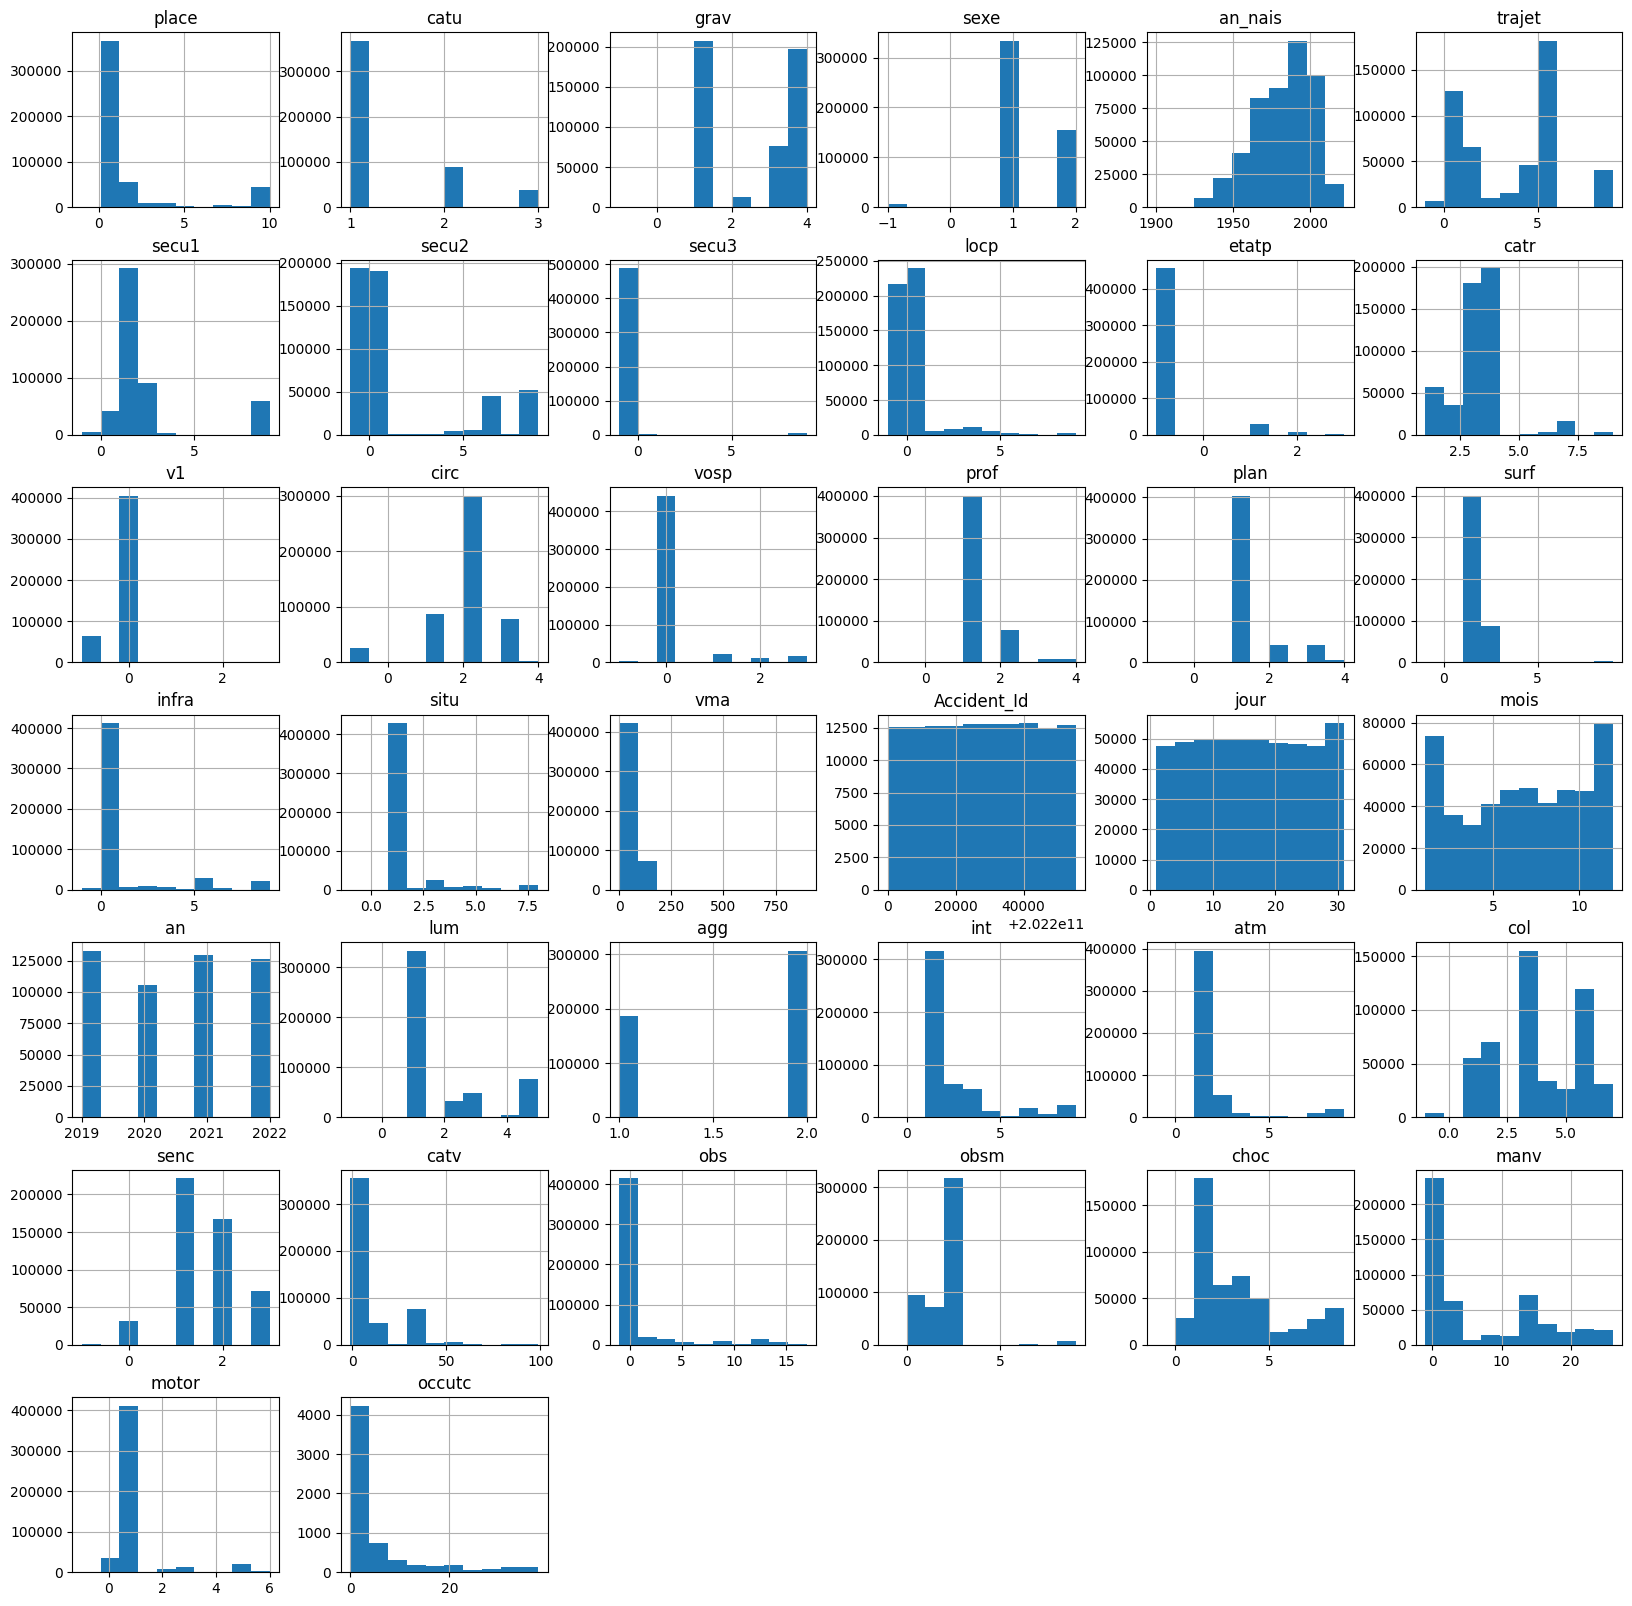

In [21]:
df.hist(figsize=(20, 20))
plt.show()

## Nettoyage des données

#### Suppression des données données contenant trop de manquants

In [22]:
# suppression + 90% mqt
df_temp = df.columns[(df.isna().sum()/len(df)*100) < 90]
df = df[df_temp]
(df.isna().sum()/len(df)*100)

# suppression lignes nan
#df = df.dropna()
(df.isna().sum()/len(df)*100)

# suppression des variables doublons
df = df.drop(["adr", "voie", "id_vehicule"], axis=1)
df

# suppression de variables non-pertinentes
df = df.drop(["pr", # Numéro du PR de rattachement (numéro de la borne)
              "pr1" # Distance du PR de rattachement en mètre
              ], axis=1)

## Visualisation des données

### Profil des usagers ayant eu des accident 

Deux analyses sont réalisées pour les usagers ayant eu des accident :
- Nombre d'accidents en fonction du genre
- Nombre d'accidents en fonction de l'âge

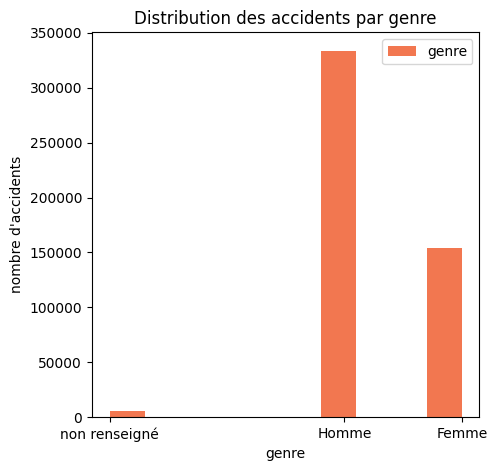

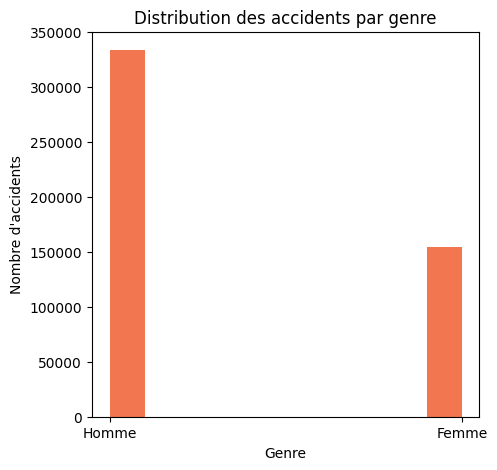

In [38]:
# Nombre d'accidents en fonction du genre

df.sexe.value_counts() 

plt.figure(figsize= (5, 5))
plt.hist(df['sexe'],  color = ['#f27750'], label = ['genre'])

plt.xlabel("genre")
plt.ylabel("nombre d'accidents")
plt.xticks([-1, 1, 2], ['non renseigné','Homme', 'Femme'])
plt.title('Distribution des accidents par genre')
plt.legend();

df_genre = df.copy()
df_genre = df.loc[(df['sexe'] == 1) | (df['sexe'] == 2)]

plt.figure(figsize= (5, 5))
plt.hist(df_genre['sexe'],  color = ['#f27750'], label = ['genre'])

plt.xlabel("Genre")
plt.ylabel("Nombre d'accidents")
plt.xticks([1, 2], ['Homme', 'Femme'])
plt.title('Distribution des accidents par genre')
plt.show();

Les hommes sont fortement représentés dans les accidents. Il y a des profils d'usagers dont le genre n'a pas été renseigné.

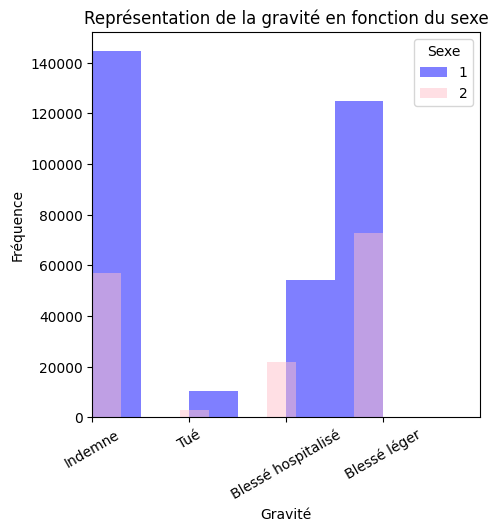

In [39]:
# Représentation des accidents en fonction du genre et de la gravité

colors = {1: 'blue', 2: 'pink', -1:'green'}  

plt.figure(figsize=(5, 5))

for sexe, data in df_genre.groupby('sexe'):
    plt.hist(data['grav'], color=colors[sexe], label=sexe, alpha=0.5) 

plt.legend(title='Sexe')
plt.xlabel('Gravité')
plt.xlim(1,5)
plt.xticks([1, 2, 3, 4], ['Indemne', 'Tué' ,'Blessé hospitalisé','Blessé léger'], rotation=30)
plt.ylabel('Fréquence')
plt.title('Représentation de la gravité en fonction du sexe')
plt.show()

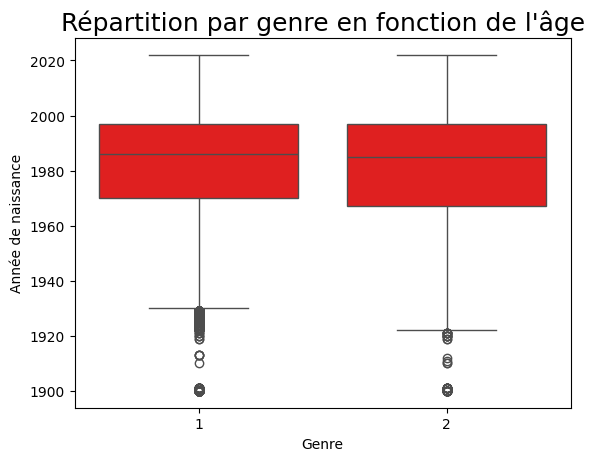

In [41]:
sns.boxplot(data=df_genre, x='sexe', y='an_nais', color='red')

plt.title("Répartition par genre en fonction de l'âge", fontsize =18)
plt.xlabel("Genre")
plt.ylabel("Année de naissance")
plt.show;

/tmp/ipykernel_131127/1702018626.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


<Figure size 1000x500 with 0 Axes>

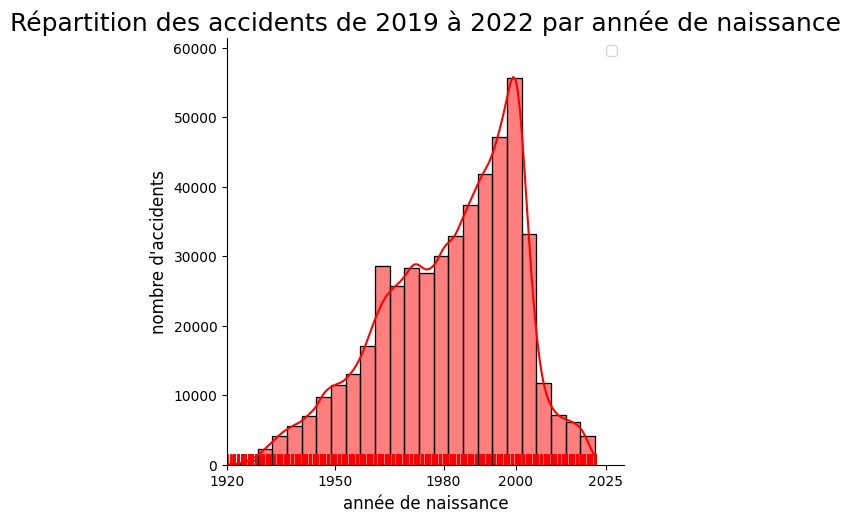

In [ ]:
# Nombre d'accidents en fonction de l'âge
plt.figure(figsize= (10, 5))
sns.displot(df.an_nais, kde=True, bins=30, rug = True, color='red')

plt.xlabel("année de naissance", fontsize = 12)
plt.ylabel("nombre d'accidents", fontsize = 12)
plt.xticks([1920, 1950, 1980, 2000, 2025])
plt.xlim([1920, 2030])
plt.title('Répartition des accidents de 2019 à 2022 par année de naissance', fontsize = 18)
plt.legend();

In [ ]:
print("L'usager le plus âgé impliqué dans un accident est :", df.an_nais.min(),
      "et l'usager le plus jeune impliqué dans un accident est :", df.an_nais.max())

L'usager le plus âgé impliqué dans un accident est : 1900.0 et l'usager le plus jeune impliqué dans un accident est : 2022.0


On observe une forte représentation de profil d'usagers ayant la vingtaine qui a été impliqués dans un accident.

Pour **conclure** sur le profil des usagers ayant eu des accident, il y a une forte représentation d'hommes, et d'âge proche de la vingtaine.

### 

### Typologie des accidents

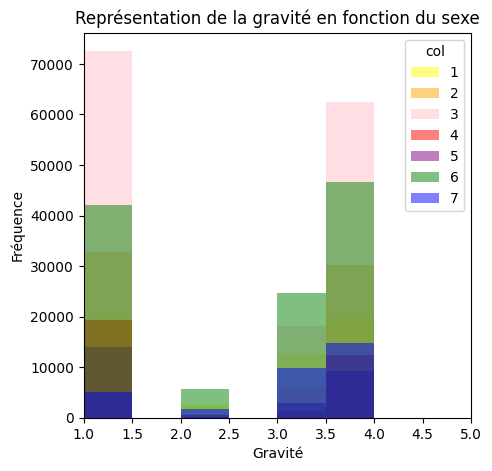

In [68]:
# Représentation des accidents en fonction du genre et du type de la colision

colors = {1: 'yellow', 2: 'orange', 3:'pink', 4:'red', 5:'purple', 6:'green', 7:'blue'}  

plt.figure(figsize=(5, 5))

for col, data in df_col.groupby('col'):
    plt.hist(data['grav'], color=colors[col], label=col, alpha=0.5) 

plt.legend(title='col')
plt.xlabel('Gravité')
plt.xlim(1,5)
#plt.xticks([1, 2, 3, 4], ['Indemne', 'Tué' ,'Blessé hospitalisé','Blessé léger'], rotation=30)
plt.ylabel('Fréquence')
plt.title('Représentation de la gravité en fonction du sexe')
plt.show()

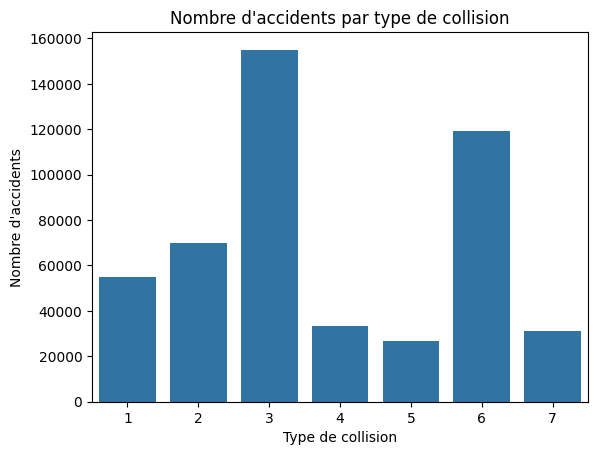

In [59]:
df_col = df.loc[df['col'] >= 1]
sns.countplot(x = df_col['col'])

plt.title("Nombre d'accidents par type de collision")
plt.xlabel("Type de collision")
plt.ylabel("Nombre d'accidents")
plt.show();

Le type de collision étant définit comme suivant : 
- -1 : Non renseigné
- 1 : Deux véhicules - frontale
- 2 : Deux véhicules – par l’arrière
- 3 : Deux véhicules – par le coté
- 4 : Trois véhicules et plus – en chaîne
- 5 : Trois véhicules et plus - collisions multiples
- 6 : Autre collision
- 7 : Sans collision

On observe que le type de collision le plus fréquent est un accident impliquant 2 véhicules ont une collision par le coté. La catégorie 'autre collision' étant trop vague, on ne pourra pas l'expliquer.

In [ ]:
df.head()

,Num_Acc,id_usager,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor
0,202200000001,1 099 700,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,2,0,2,1,9,1
1,202200000001,1 099 701,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,7,0,2,2,1,1
2,202200000002,1 099 698,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,7,0,2,8,15,1
3,202200000002,1 099 699,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,10,0,2,1,1,1
4,202200000003,1 099 696,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1,3,0.0,-1,2,0,1,1,-1,1,5,1,50,2.022000e+11,20,10,2022,17:15,1,22,22360,2,6,1,2,"48,4931620000","-2,7604390000",2,7,0,2,1,2,1


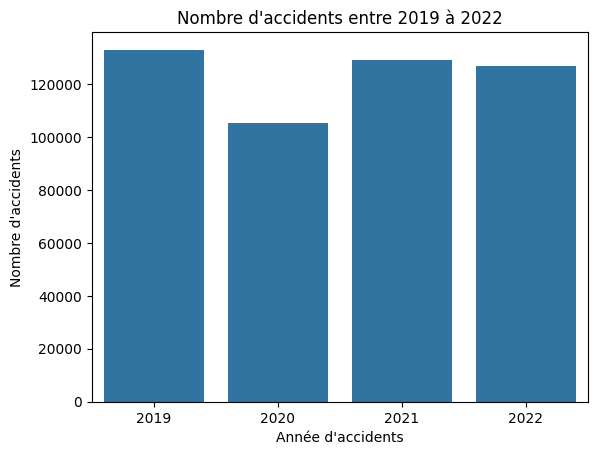

In [ ]:
df['grav'].sum() # 1 251 081 tués de 2019 à 2022

df['Num_Acc'] = df['Num_Acc'].astype(str)
df['an_acc'] = df['Num_Acc'].str.slice(0,4).astype(int)

sns.countplot(x = df['an_acc'])

plt.title("Nombre d'accidents entre 2019 à 2022")
plt.xlabel("Année d'accidents")
plt.ylabel("Nombre d'accidents")
plt.show();

On observe une baisse des accidents en 2020, cela est peut être dû aux confinenements et aux restrictions suite à la période Covid.

### Représentation de la gravité des accidents par année d'accidents

In [ ]:
df.groupby(['an_acc', 'grav']).size().unstack()

grav,-1,1,2,3,4
an_acc,,,,,
2019,NaN,55314.0,3498.0,20858.0,53307.0
2020,NaN,43267.0,2780.0,16775.0,42473.0
2021,60.0,55143.0,3219.0,19093.0,51733.0
2022,241.0,53630.0,3550.0,19260.0,49981.0


In [ ]:
# Evolution de décès par rapport aux années précédentes :

dec22 = (3550 - 3219)/3550*100 # par rapport à 2021 = + 9.32 %

dec21 = (3219-2780)/3219*100 # par rapport à 2020 = + 13.64 %

dec20 = (2780-3498)/2780*100 # par rapport à 2019 = - 25.83 %

In [63]:
df.loc[df['grav'] >= 1]

,Num_Acc,id_usager,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor
0,202200000001,1 099 700,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,2,0,2,1,9,1
1,202200000001,1 099 701,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,19,10,2022,16:15,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,7,0,2,2,1,1
2,202200000002,1 099 698,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,7,0,2,8,15,1
3,202200000002,1 099 699,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1,1,0,1,50,2.022000e+11,20,10,2022,08:34,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,10,0,2,1,1,1
4,202200000003,1 099 696,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1,3,0.0,-1,2,0,1,1,-1,1,5,1,50,2.022000e+11,20,10,2022,17:15,1,22,22360,2,6,1,2,"48,4931620000","-2,7604390000",2,7,0,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494177,201900058837,NaN,C01,1,1,4,2,1988.0,1,1,0,-1,-1,-1,-1,1,0.0,1,2,0,1,1,NaN,2,0,1,90,NaN,27,11,2019,07:50,1,67,67482,1,1,8,4,"48,5769000","7,7269000",1,7,0,2,1,2,1
494178,201900058838,NaN,A01,1,1,4,1,1998.0,9,1,0,-1,-1,-1,-1,1,0.0,3,3,0,1,1,NaN,1,0,1,90,NaN,30,11,2019,02:41,4,94,94021,1,1,1,6,"48,7717000","2,3457600",2,7,3,0,1,21,0
494179,201900058839,NaN,A01,1,1,3,1,1979.0,0,2,0,-1,-1,-1,-1,1,0.0,1,1,0,1,3,NaN,1,0,1,50,NaN,30,11,2019,15:20,1,78,78640,1,1,1,7,"48,7772890","2,2237590",2,33,0,0,7,1,1
494180,201900058840,NaN,B01,1,1,4,1,1974.0,0,1,0,-1,-1,0,-1,1,0.0,1,3,0,1,1,NaN,1,0,2,110,NaN,29,11,2019,20:50,3,92,92047,1,1,1,2,"48,8351236","2,1751101",1,10,0,2,4,0,2


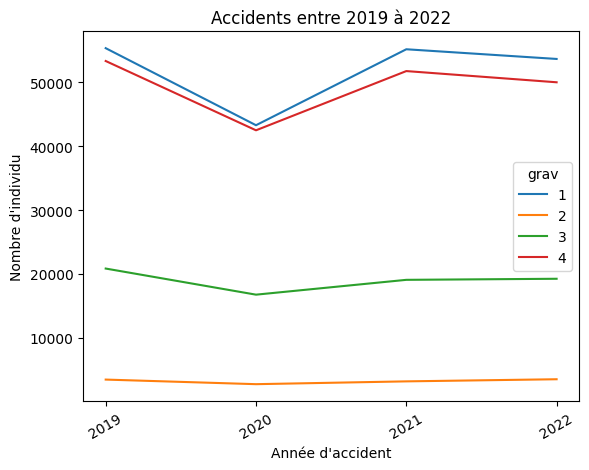

In [64]:
df_annee = df.loc[df['grav'] >= 1]
df_annee.groupby(['an', 'grav']).size().unstack().plot()

plt.title("Accidents entre 2019 à 2022")
plt.xlabel("Année d'accident")
plt.ylabel("Nombre d'individu")
plt.xticks([2019, 2020, 2021, 2022], rotation=30)
plt.show();

Pour rappel : 
- -1 : non concerné
- 1 – Indemne
- 2 – Tué
- 3 – Blessé hospitalisé
- 4 – Blessé léger

En 2020, on observe une diminution des accidents et également de la gravité; à partir de 2021, on observe un label "-1" qui apparaît. On peut se demander en quoi il consiste et ensuite se demander s'il est pertinent de garder cette information puisqu'en 2021 60 personnes sont concernées et 241 en 2022.

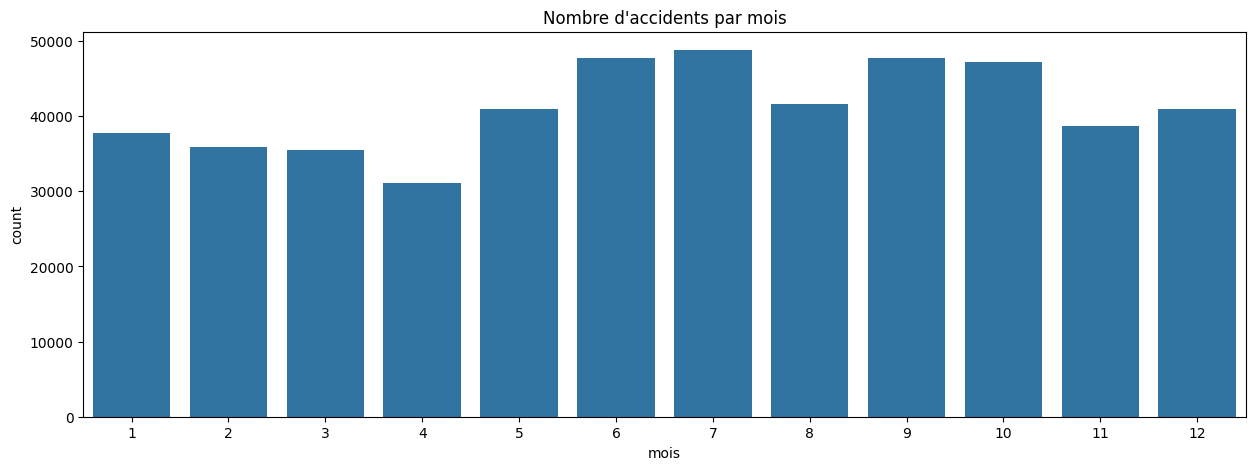

In [ ]:
plt.figure(figsize = (15, 5))

sns.countplot(x = df['mois'])
plt.title("Nombre d'accidents par mois")
plt.show()

## Pré-processing des données

In [8]:
df_bis = df.copy()
# transformation des variables qui contiennent du texte et des erreurs en variables numériques
df_bis['actp'] = df_bis['actp'].str.replace('A', '10')
df_bis['actp'] = df_bis['actp'].str.replace('B', '11')

#df_bis['pr1'] = df_bis['pr1'].str.replace('nan', 'NaN')

#df_bis['pr'] = df_bis['pr'].str.replace("(1)", '1')

#df_bis['pr1'] = df_bis['pr1'].str.replace("(1)", '1')

In [9]:
# nombre de valeurs uniques
print(df_bis.nbv.unique())

['2' '1' '4' '3' '6' '0' '9' '8' ' -1' '5' '7' '12' '10' '#ERREUR' '11' 2
 3 4 1 5 0 6 -1 8 10 9 7 12 11]


In [10]:
# nbv
# transformer les variables numériques en variables textes
df_bis['nbv'] = df_bis['nbv'].replace([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                                      ['-1','0','1','2', "3", '4', '5', '6', '7', '8', '9', '10', '11', '12'])

df_bis['nbv'] = df_bis['nbv'].str.replace(' -1', '-1')
df_bis['nbv'] = df_bis['nbv'].str.replace('#ERREUR', '13')

print(df_bis.nbv.unique())
df_bis.nbv.value_counts()

['2' '1' '4' '3' '6' '0' '9' '8' '-1' '5' '7' '12' '10' '13' '11']


nbv
2     294193
4      63139
1      46679
3      41387
6      14756
0      11360
5       9203
-1      4785
8       4780
7       1598
10      1127
9        740
12       240
11       193
13         2
Name: count, dtype: int64

In [11]:
# larrout

# Convertir toutes les valeurs en chaînes de caractères
df_bis["larrout"] = [str(value) for value in df_bis["larrout"]]

# remplacer les nan en 0
df_bis['larrout'] = df_bis['larrout'].str.replace('nan', '0')

# remplacer les virgules par des points
df_bis.larrout = [value.replace(',', '.') for value in df_bis.larrout]

# enlever l'espace avant la négation
df_bis['larrout'] = df_bis['larrout'].str.replace(' -1', '-1')

# transformer en float
df_bis["larrout"] = df_bis["larrout"].astype(float)


df_bis.larrout.value_counts()

larrout
-1.00     339208
 0.00     132708
 4.00       6540
 5.00       2964
 7.00       2605
           ...  
 5.79          1
 3.75          1
 13.30         1
 82.00         1
 13.85         1
Name: count, Length: 188, dtype: int64

In [ ]:
# hrnm

# séparer les heures des minutes
sepa_values = [value.split(':') for value in df_bis["hrmn"] ]

# création de la variable heure et la variable minute
df_bis["heure"] = [value[0] for value in sepa_values]
df_bis["minute"] = [value[1] for value in sepa_values]

# suppression de la variable hrmn
df_bis = df_bis.drop(["hrmn"], axis=1)
df_bis

,Num_Acc,id_usager,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,Accident_Id,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,an_acc,heure,minute
0,202200000001,1 099 700,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1.0,1,0,1,50,2.022000e+11,19,10,2022,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,2,0,2,1,9,1,2022,16,15
1,202200000001,1 099 701,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1,4,0.0,2,2,0,1,1,-1.0,1,0,1,50,2.022000e+11,19,10,2022,1,26,26198,2,3,1,3,"44,5594200000","4,7257200000",1,7,0,2,2,1,1,2022,16,15
2,202200000002,1 099 698,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1.0,1,0,1,50,2.022000e+11,20,10,2022,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,7,0,2,8,15,1,2022,08,34
3,202200000002,1 099 699,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1,4,0.0,2,2,0,1,1,-1.0,1,0,1,50,2.022000e+11,20,10,2022,1,25,25204,2,3,1,3,"46,9258100000","6,3462000000",2,10,0,2,1,1,1,2022,08,34
4,202200000003,1 099 696,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1,3,0.0,-1,2,0,1,1,-1.0,1,5,1,50,2.022000e+11,20,10,2022,1,22,22360,2,6,1,2,"48,4931620000","-2,7604390000",2,7,0,2,1,2,1,2022,17,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494177,201900058837,NaN,C01,1,1,4,2,1988.0,1,1,0,-1,-1,-1,-1,1,0.0,1,2,0,1,1,0.0,2,0,1,90,NaN,27,11,2019,1,67,67482,1,1,8,4,"48,5769000","7,7269000",1,7,0,2,1,2,1,2019,07,50
494178,201900058838,NaN,A01,1,1,4,1,1998.0,9,1,0,-1,-1,-1,-1,1,0.0,3,3,0,1,1,0.0,1,0,1,90,NaN,30,11,2019,4,94,94021,1,1,1,6,"48,7717000","2,3457600",2,7,3,0,1,21,0,2019,02,41
494179,201900058839,NaN,A01,1,1,3,1,1979.0,0,2,0,-1,-1,-1,-1,1,0.0,1,1,0,1,3,0.0,1,0,1,50,NaN,30,11,2019,1,78,78640,1,1,1,7,"48,7772890","2,2237590",2,33,0,0,7,1,1,2019,15,20
494180,201900058840,NaN,B01,1,1,4,1,1974.0,0,1,0,-1,-1,0,-1,1,0.0,1,3,0,1,1,0.0,1,0,2,110,NaN,29,11,2019,3,92,92047,1,1,1,2,"48,8351236","2,1751101",1,10,0,2,4,0,2,2019,20,50


In [ ]:
# dep

# remplacer les dpt 2A et 2B par 20
df_bis['dep'] = df_bis['dep'].str.replace('2A', '20')
df_bis['dep'] = df_bis['dep'].str.replace('2B', '20')

df_bis["dep"].unique()

array(['26', '25', '22', '16', '13', '12', '10', '09', '06', '03', '02',
       '75', '94', '93', '92', '76', '68', '972', '63', '62', '51', '20',
       '65', '33', '71', '89', '61', '29', '38', '14', '60', '45', '73',
       '53', '24', '27', '17', '48', '973', '77', '67', '988', '08', '56',
       '69', '91', '78', '64', '59', '49', '42', '37', '34', '32', '31',
       '11', '35', '47', '86', '01', '74', '79', '46', '39', '72', '05',
       '18', '19', '971', '987', '66', '84', '85', '95', '57', '54', '52',
       '50', '44', '974', '83', '28', '15', '07', '80', '30', '41', '82',
       '55', '43', '40', '04', '986', '88', '36', '87', '21', '976', '81',
       '58', '70', '90', '23', '977', '978', '975', '2', '9', '7', '4',
       '3', '1', '6', '5', '8'], dtype=object)

In [ ]:
# com

# remplacer les communes de la Corse par 20
df_bis['com'] = df_bis['com'].str.replace('B', '0')
df_bis['com'] = df_bis['com'].str.replace('A', '0')
df_bis['com'] = df_bis['com'].str.replace('N/C', '14061')


In [ ]:
# lat

# Convertir toutes les valeurs en chaînes de caractères
df_bis["lat"] = [str(value) for value in df_bis["lat"]]

# remplacer les virgules par des points
df_bis["lat"] = [value.replace(',', '.') for value in df_bis["lat"]]

In [ ]:
# long

# Convertir toutes les valeurs en chaînes de caractères
df_bis["long"] = [str(value) for value in df_bis["long"]]

# remplacer les virgules par des points
df_bis["long"] = [value.replace(',', '.') for value in df_bis["long"]]

In [ ]:
df_bis["actp"] = df_bis["actp"].astype(int)
df_bis["nbv"] = df_bis["nbv"].astype(int)
df_bis["heure"] = df_bis["heure"].astype(int)
df_bis["minute"] = df_bis["minute"].astype(int)
df_bis["dep"] = df_bis["dep"].astype(int)
df_bis["com"] = df_bis["com"].astype(int)
df_bis["lat"] = df_bis["lat"].astype(float)
df_bis["long"] = df_bis["long"].astype(float)

In [ ]:
# variables non numériques
df_bis.select_dtypes(exclude='number').columns

Index(['Num_Acc', 'id_usager', 'num_veh'], dtype='object')

In [ ]:
df_bis = df_bis.drop(['Num_Acc', "id_usager", 'num_veh'], axis=1)

### Matrice de corrélation

Text(0.5, 1.0, 'Variables corrélées avec la variable cible : gravité')

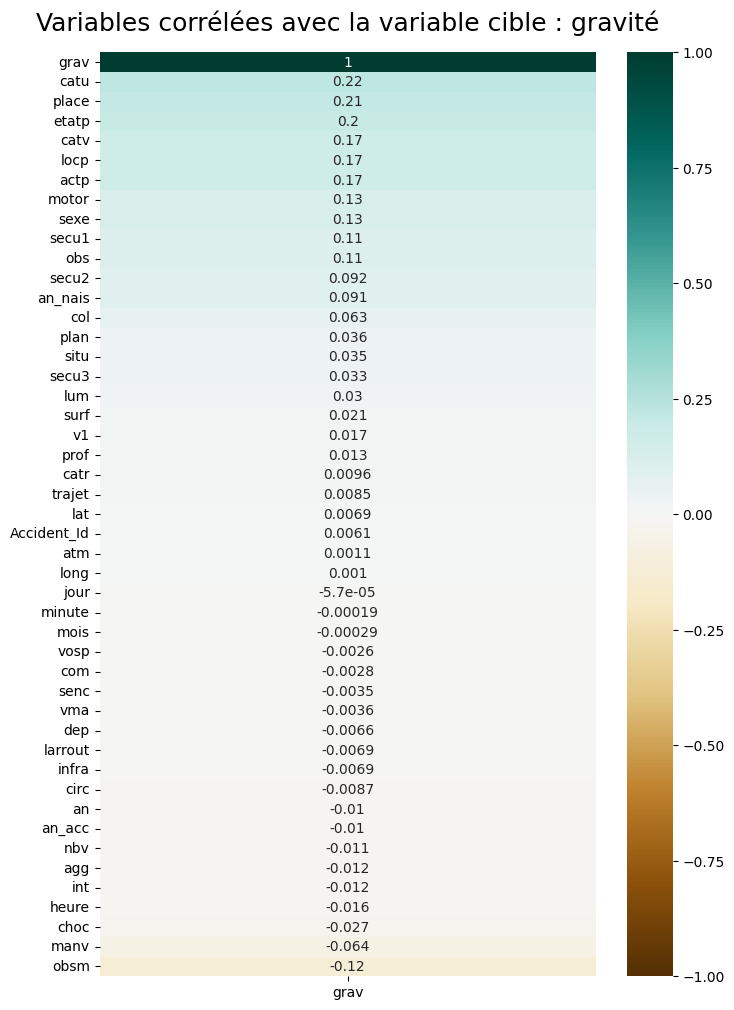

In [ ]:
# corrélation avec la variable cible
sorted_corrs_t = df_bis.corr()['grav'].abs().sort_values(ascending=False)
sorted_corrs_t

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_bis.corr()[['grav']].sort_values(by='grav', 
                                                                   ascending=False), vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Variables corrélées avec la variable cible : gravité', fontdict={'fontsize':18}, pad=16)

### Sauvegarde du dataset final

In [ ]:
df_bis.to_csv('dataset_final.csv', index=False)

##### Travail en cours :

In [ ]:
# combiner les variables indemne et non concerné car si la personne 
# n'est pas concerné par la gravité c'est qu'elle est indemne

df_ter = df_bis.copy()
df_ter.grav = df_ter.grav.astype(str)
df_ter.grav = [value.replace("-1", "1") for value in df_ter["grav"]]
df_ter.grav = df_ter.grav.astype(int)

print(df_ter.grav.value_counts())

print("-1 : non concerné, 1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger")

# Pour la suite, je souhaite conserver pour la variable gravité les catégories indemne, tué, blessé hospitalisé 
# et blessé léger qui ma paraissent intéressantes pour traiter le problème

# L'une des possibilités est de ré-équilibrer mon jeu de données dans la partie modélisation avec "class_weight =balanced"


grav
1    207655
4    197494
3     75986
2     13047
Name: count, dtype: int64
-1 : non concerné, 1 – Indemne, 2 – Tué, 3 – Blessé hospitalisé, 4 – Blessé léger


## Modélisation

### Séparation du jeu de données en train set et test set

In [ ]:

df_qua = df_ter.copy()
df_qua = df_qua.drop(['Accident_Id', 
                      "an_acc"], # doublon avec la variable "an"
                     axis=1)

df_qua = df_qua.dropna()
# Séparation du jeu de données pour entraîner le modèle
#train = df_qua.loc[df_qua.an.between(2019, 2021)] 
train = df_qua.loc[df_qua.an.between(2020, 2021)]
test = df_qua.loc[df_qua.an == 2022]

print("DF: ", df_qua.shape,"TRAIN :", train.shape,"TEST :", test.shape)
print(" ")
print("La proportion du dataset train est de", round((train.shape[0]/ df_qua.shape[0]*100)),
      "% et du dataset test est de", round((test.shape[0]/ df_qua.shape[0]*100)), "%.")
print(" ")
X_train = train.drop(["grav"], axis=1)
y_train = train.grav

X_test = test.drop(["grav"], axis=1)
y_test = test.grav

print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

DF:  (463645, 45) TRAIN : (231476, 45) TEST : (123788, 45)
 
La proportion du dataset train est de 50 % et du dataset test est de 27 %.
 
Séparation des labels et targets : (231476, 44) (123788, 44) (231476,) (123788,)


In [ ]:
df_qua[df_qua.isna().any(axis=1)]

,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,catr,v1,circ,nbv,vosp,prof,plan,larrout,surf,infra,situ,vma,jour,mois,an,lum,dep,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,heure,minute


## Réduire les écarts de dimensions

rescale les features pour réduire les écarts de dimentsions

In [ ]:
from sklearn.preprocessing import RobustScaler

rbs = RobustScaler().fit(X_train)
X_train_scaled = rbs.transform(X_train)
X_test_scaled = rbs.transform(X_test)

### Standar scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled_std = scaler.fit_transform(X_train)
X_test_scaled_std = scaler.transform(X_test)

### Features select

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

best_accuracy = 0
best_k = 0

for k in range(1, X_train_scaled.shape[1] + 1):
    select_k_best = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best = select_k_best.fit_transform(X_train_scaled, y_train)
    X_test_k_best = select_k_best.transform(X_test_scaled)
    
    model_2 = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_2.fit(X_train_k_best, y_train)
    
    y_pred = model_2.predict(X_test_k_best)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print("Best number of features:", best_k)
print("Best accuracy:", best_accuracy)

Best number of features: 33
Best accuracy: 0.5848305166898246


In [ ]:
# /!\ Avec standar scaler

best_accuracy_std = 0
best_k_std = 0

for k in range(1, X_train_scaled_std.shape[1] + 1):
    select_k_best_std = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best_std = select_k_best_std.fit_transform(X_train_scaled_std, y_train)
    X_test_k_best_std = select_k_best_std.transform(X_test_scaled_std)
    
    model_2_std = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_2_std.fit(X_train_k_best_std, y_train)
    
    y_pred_std = model_2_std.predict(X_test_k_best_std)
    accuracy_std = accuracy_score(y_test, y_pred_std)
    
    if accuracy_std > best_accuracy_std:
        best_accuracy_std = accuracy_std
        best_k_std = k

print("Best number of features:", best_k_std)
print("Best accuracy:", best_accuracy_std)

Best number of features: 33
Best accuracy: 0.5848143600348984


Aucun changement avec le standar scaler.

In [ ]:
# sélection des k des meilleures features définies précédemment
test_stat =  SelectKBest(f_classif, k=33)
test_stat.fit(X_train_scaled, y_train)

for col, score in zip(X_train.columns, test_stat.scores_):
    print(col, ":", score)

X_train_selected = test_stat.transform(X_train_scaled)
X_test_selected = test_stat.transform(X_test_scaled)

place : 3751.02705471995
catu : 3932.939450001851
sexe : 663.432918581096
an_nais : 1201.3510102527455
trajet : 149.05544853172466
secu1 : 395.71118106524386
secu2 : 615.456351478097
secu3 : 1110.0055405642986
locp : 4141.429526818307
actp : 3986.073214205416
etatp : 3689.6066179078075
catr : 59.86231393996461
v1 : 3796.3966448993556
circ : 115.12844283720082
nbv : 613.280750996255
vosp : 197.0816289130131
prof : 299.7284278727152
plan : 1010.8092305804419
larrout : 79.75480586818664
surf : 74.37654817515048
infra : 3.801036830412564
situ : 1049.882785340523
vma : 452.162177423753
jour : 1.385584650158238
mois : 0.3863094406076514
an : 10.78881386395521
lum : 136.74450492455713
dep : 25.878304199677014
com : 974.4510658142017
agg : 2153.1772524713892
int : 178.16552801281452
atm : 27.788935789589
col : 1375.7678352778917
lat : 149.36146455331314
long : 9.335137534866124
senc : 9.284202599259116
catv : 2630.097827075264
obs : 3158.4853218570706
obsm : 2652.761386204269
choc : 336.370926

In [ ]:
# /!\ avec standar scaler 

# sélection des k des meilleures features définies précédemment
test_stat_std =  SelectKBest(f_classif, k=33)
test_stat_std.fit(X_train_scaled_std, y_train)

#for col, score in zip(X_train.columns, test_stat_std.scores_):
#    print(col, ":", score)

X_train_selected_std = test_stat_std.transform(X_train_scaled_std)
X_test_selected_std = test_stat_std.transform(X_test_scaled_std)

## Baseline

In [ ]:
from sklearn.dummy import DummyClassifier

for strategy in ['stratified','most_frequent','prior',
               'uniform']:
    model_dummy = DummyClassifier(strategy = strategy)
    model_dummy.fit(X_train_selected, y_train)
    
    print("The %s's accuracy is %f"%(strategy,model_dummy.score(X_test_selected, y_test)))



The stratified's accuracy is 0.357030
The most_frequent's accuracy is 0.411970
The prior's accuracy is 0.411970
The uniform's accuracy is 0.251721


### Régression logistique

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model_baseline = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
model_baseline.fit(X_train_selected, y_train)
accuracy = model_baseline.score(X_test_selected, y_test)
print("Accuracy :", round(accuracy,6))

Accuracy : 0.584831


Matrice de confusion :
 [[39028     1   938 11030]
 [ 1228     0   860  1462]
 [ 5993     0  3355  9912]
 [18008     0  1961 30012]]


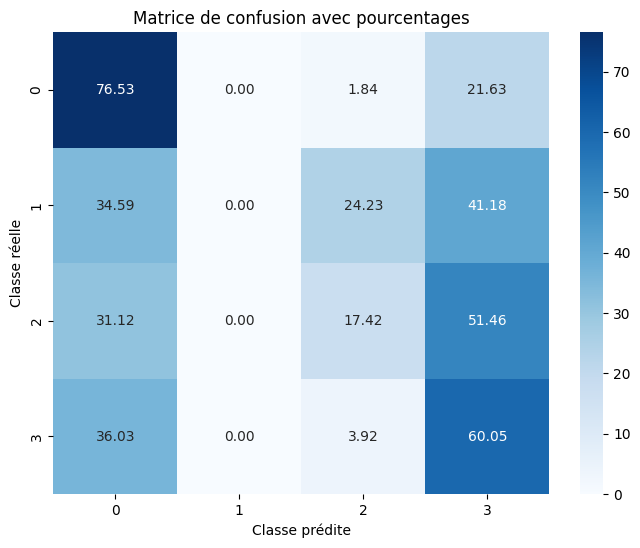

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_log = model_baseline.predict(X_test_selected)

conf_matrix_log = confusion_matrix(y_test, y_pred_log)
print("Matrice de confusion :\n", conf_matrix_log)

row_sums_log = conf_matrix_log.sum(axis=1)
conf_matrix_percent_log = (conf_matrix_log.T / row_sums_log).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_log, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

On observe dans la matrice de confusion que le modèle a dû mal à prédire la classe "tué", très certainement car les classes ne sont pas proportionnelles entre elles.

In [ ]:

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

model_baseline_res = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
model_baseline_res.fit(X_train_resampled, y_train_resampled)
accuracy_res = model_baseline_res.score(X_test_selected, y_test)
print("Accuracy :", round(accuracy_res,6))

y_pred = model_baseline_res.predict(X_test_selected)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

print(classification_report_imbalanced(y_test, y_pred))


Accuracy : 0.502819
Predictions      1     2     3      4
grav                                 
1            33332  6287  3208   8170
2              399  2132   606    413
3             2844  7106  4691   4619
4            14265  7624  6004  22088
                   pre       rec       spe        f1       geo       iba       sup

          1       0.66      0.65      0.76      0.65      0.70      0.49     50997
          2       0.09      0.60      0.83      0.16      0.70      0.48      3550
          3       0.32      0.24      0.91      0.28      0.47      0.21     19260
          4       0.63      0.44      0.82      0.52      0.60      0.35     49981

avg / total       0.58      0.50      0.81      0.53      0.63      0.39    123788



In [ ]:
# /!\ avec standar scaler 

model_baseline_log_std = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
model_baseline_log_std.fit(X_train_selected_std, y_train)
accuracy_log_std = model_baseline_log_std.score(X_test_selected_std, y_test)
print("Accuracy :", round(accuracy_log_std,6))

Accuracy : 0.584814


### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_baseline_rf = RandomForestClassifier(random_state=0)
model_baseline_rf.fit(X_train_selected, y_train)
accuracy_rf = model_baseline_rf.score(X_test_selected, y_test)

print("Accuracy of the baseline Random Forest model:", round(accuracy_rf, 4))

Accuracy of the baseline Random Forest model: 0.6626


In [ ]:
# /!\ avec std

model_baseline_rf_std = RandomForestClassifier(random_state=0)
model_baseline_rf_std.fit(X_train_selected_std, y_train)
accuracy_rf_std = model_baseline_rf_std.score(X_test_selected_std, y_test)

print("Accuracy of the baseline Random Forest model:", round(accuracy_rf_std, 4))

Accuracy of the baseline Random Forest model: 0.663


### Xgboost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_baseline_gb = GradientBoostingClassifier(random_state=0)
model_baseline_gb.fit(X_train_selected, y_train)
accuracy_gb = model_baseline_gb.score(X_test_selected, y_test)

print("Accuracy of the baseline Gradient Boosting model:", round(accuracy_gb, 6))

Accuracy of the baseline Gradient Boosting model: 0.65924


In [ ]:
# /!\ avec std

model_baseline_gb_std = GradientBoostingClassifier(random_state=0)
model_baseline_gb_std.fit(X_train_selected_std, y_train)
accuracy_gb_std = model_baseline_gb_std.score(X_test_selected_std, y_test)

print("Accuracy of the baseline Gradient Boosting model:", round(accuracy_gb_std, 6))

Accuracy of the baseline Gradient Boosting model: 0.65924


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=4)
model_knn.fit(X_train_selected, y_train)
accuracy_knn = model_knn.score(X_test_selected, y_test)

print("Accuracy of the KNeighborsClassifier model:", round(accuracy_knn, 6))

Accuracy of the KNeighborsClassifier model: 0.591964


In [ ]:
# /!\ avec std

model_knn_std = KNeighborsClassifier(n_neighbors=4)
model_knn_std.fit(X_train_selected_std, y_train)
accuracy_knn_std = model_knn_std.score(X_test_selected_std, y_test)

print("Accuracy of the KNeighborsClassifier model:", round(accuracy_knn_std, 6))

Accuracy of the KNeighborsClassifier model: 0.573182


## Bibiographie :

- base de données : https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/#/resources

- documentation : https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2022/#/resources/8ef4c2a3-91a0-4d98-ae3a-989bde87b62a


